In [1]:
import pyvene as pv
import torch

In [2]:
import os
from copy import deepcopy

import numpy as np
from tqdm.notebook import tqdm
import pandas as pd
from datasets import load_dataset

%config InlineBackend.figure_formats = ['svg']
from plotnine import (
    ggplot,
    geom_tile,
    aes,
    theme,
    element_text,
    ggtitle,
    xlab, ylab, ggsave,
    facet_wrap
)
from plotnine.scales import scale_y_reverse, scale_fill_cmap

In [3]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"

In [4]:
def embed_to_distrib(model, embed, log=False, logits=False):
    if 'llama' in model.config.architectures[0].lower():
        with torch.inference_mode():
            vocab = torch.matmul(embed, model.lm_head.weight.T)
            if logits:
                return vocab
            return torch.nn.functional.log_softmax(vocab, dim=2) if log else torch.nn.functional.softmax(vocab, dim=2)
    else:
        vocab = pv.embed_to_distrib(model, embed, logits=logits)
        return vocab

# factual recall
def factual_recall(text, model, tokenizer):
    print(text)
    base = deepcopy(text)
    inputs = [
        tokenizer(base, return_tensors="pt").to(device),
    ]
    base = deepcopy(text)
    for i in range(len(inputs)):
        res = model(**inputs[i], output_hidden_states=True)
        last = res.last_hidden_state if hasattr(res, 'last_hidden_state') else res.hidden_states[-1]
        distrib = embed_to_distrib(model, last, logits=False)
        pv.top_vals(tokenizer, distrib[0][-1], n=10)
        
# corrupted run - add Gaussian noise to embeddings of subject
class NoiseIntervention(pv.ConstantSourceIntervention, pv.LocalistRepresentationIntervention):
    def __init__(self, embed_dim, **kwargs):
        super().__init__()
        self.interchange_dim = embed_dim
        self.seq_len = kwargs.get("seq_len", 1)
        rs = np.random.RandomState(1)
        prng = lambda *shape: rs.randn(*shape)
        self.noise = torch.from_numpy(
            prng(1, self.seq_len, embed_dim)).to(device)
        self.noise_level = 0.13462981581687927

    def forward(self, base, source=None, subspaces=None): 
        # source argument is ignored unlike in causal interventions, since we are adding noise without reference to any other input
        base[..., : self.interchange_dim] += self.noise * self.noise_level
        return base

    def __str__(self):
        return f"NoiseIntervention(embed_dim={self.embed_dim}, seq_len={self.seq_len})"


def corrupted_config(model_type, seq_len):
    config = pv.IntervenableConfig(
        model_type=model_type,
        representations=[
            pv.RepresentationConfig(
                0,              # layer
                "block_input",  # intervention type
            ),
        ],
        intervention_types=NoiseIntervention,
        seq_len=seq_len,
    )
    return config

def corrupted_recall(text, model, tokenizer, subject_pos):
    print(text)
    base = tokenizer(deepcopy(text), return_tensors="pt").to(device)
    seq_len = len(subject_pos)
    config = corrupted_config(type(model), seq_len)
    intervenable = pv.IntervenableModel(config, model)

    _, counterfactual_outputs = intervenable(
        base, unit_locations={"base": ([[subject_pos]])}
    )
    last = counterfactual_outputs.last_hidden_state if hasattr(counterfactual_outputs, 'last_hidden_state') else counterfactual_outputs.hidden_states[-1]
    distrib = embed_to_distrib(model, last, logits=False)
    pv.top_vals(tokenizer, distrib[0][-1], n=10)
    
def format_tokens(tokenizer, tokens):
    return [tokenizer.decode(tok).replace("\n", "\\n") for tok in tokens]

# restored run - corrupt input in some position, then restore the hidden state at a particular layer for some positions
def restore_corrupted_with_interval_config(
        layer, 
        stream="mlp_activation", 
        window=10, 
        num_layers=48,
        seq_len=1
    ):
    start = max(0, layer - window // 2)
    end = min(num_layers, layer - (-window // 2))
    config = pv.IntervenableConfig(
        representations=[
            pv.RepresentationConfig(
                0,       # layer
                "block_input",  # intervention type
            ),
        ] + [
            pv.RepresentationConfig(
                i,       # layer
                stream,  # intervention type
        ) for i in range(start, end)],
        intervention_types=\
            [NoiseIntervention]+[pv.VanillaIntervention]*(end-start),
        seq_len=seq_len,
    )
    return config

# corrupt all layers and positions 0, 1, 2, 3 ("The Space Needle", i.e. the subject of the fact) and restore at a single position at every layer
def restored_run(text, model, tokenizer, subject_pos, save_path):
    base = tokenizer(deepcopy(text), return_tensors="pt").to(device)
    yes_token = tokenizer.convert_tokens_to_ids("Yes")
    no_token = tokenizer.convert_tokens_to_ids("No")
    seq_len = len(subject_pos)
    
    for stream in ["block_output", "mlp_activation", "attention_output"]:
        data = []
        n_layers = model.config.n_layer if hasattr(model.config, "n_layer") else model.config.num_hidden_layers
        for layer_i in tqdm(range(n_layers)):
            for pos_i in range(len(base.input_ids[0])):
                config = restore_corrupted_with_interval_config(
                    layer_i, stream, 
                    window=1 if stream == "block_output" else 10,
                    num_layers=n_layers,
                    seq_len=seq_len
                )
                n_restores = len(config.representations) - 1
                intervenable = pv.IntervenableModel(config, model)
                _, counterfactual_outputs = intervenable(
                    base,
                    [None] + [base]*n_restores,
                    {
                        "sources->base": (
                            [None] + [[[pos_i]]]*n_restores,
                            [[subject_pos]] + [[[pos_i]]]*n_restores,
                        )
                    },
                )
                last = counterfactual_outputs.last_hidden_state if hasattr(counterfactual_outputs, 'last_hidden_state') else counterfactual_outputs.hidden_states[-1]
                distrib = embed_to_distrib(
                    model, last, logits=False
                )
                yes_prob = distrib[0][-1][yes_token].detach().cpu().item()
                no_prob = distrib[0][-1][no_token].detach().cpu().item()
                data.append({"layer": layer_i, "pos": pos_i, "yes_prob": yes_prob, "no_prob": no_prob})
        df = pd.DataFrame(data)
        if not os.path.exists(save_path):
            os.makedirs(save_path)
        df.to_csv(f"{save_path}/pyvene_rome_{stream}.csv")
        
def plot_activations(labels, breaks, colors, titles, path):
    for stream in ["block_output", "mlp_activation", "attention_output"]:
        df = pd.read_csv(f"{path}/pyvene_rome_{stream}.csv")
        df["layer"] = df["layer"].astype(int)
        df["pos"] = df["pos"].astype(int)
        df["p(Yes)"] = df["yes_prob"].astype(float)
        df["p(No)"] = df["no_prob"].astype(float)

        df_melted = df.melt(
            id_vars=["layer", "pos"],
            value_vars=["p(Yes)", "p(No)"],
            var_name="Token",
            value_name="Probability"
        )

        # Create the plot with facets
        plot = (
            ggplot(df_melted, aes(x="layer", y="pos"))
            + facet_wrap("~Token", scales="free_y")  # Side-by-side subplots for "p(Yes)" and "p(No)"
            + geom_tile(aes(fill="Probability"))
            + scale_fill_cmap(colors[stream])
            + xlab(titles[stream])
            + scale_y_reverse(
                limits=(-0.5, len(labels) - 0.5), 
                breaks=breaks, labels=labels
            )
            + ggtitle(f"{stream} Activations: p(Yes) and p(No)")
            + theme(figure_size=(10, 5))  # Adjust figure size for side-by-side plots
            + ylab("") 
            + theme(axis_text_y=element_text(angle=90, hjust=1))
        )
        display(plot)

# Load dataset

In [5]:
# Load BoolQ dataset
boolq = load_dataset("google/boolq")

In [6]:
sample = boolq["train"][2]
sample

{'question': 'is windows movie maker part of windows essentials',
 'answer': True,
 'passage': 'Windows Movie Maker (formerly known as Windows Live Movie Maker in Windows 7) is a discontinued video editing software by Microsoft. It is a part of Windows Essentials software suite and offers the ability to create and edit videos as well as to publish them on OneDrive, Facebook, Vimeo, YouTube, and Flickr.'}

## GPT-2

In [7]:
# init GPT2-XL model
config, tokenizer, gpt = pv.create_gpt2(name="gpt2-xl")
gpt.to(device)

loaded model


GPT2Model(
  (wte): Embedding(50257, 1600)
  (wpe): Embedding(1024, 1600)
  (drop): Dropout(p=0.1, inplace=False)
  (h): ModuleList(
    (0-47): 48 x GPT2Block(
      (ln_1): LayerNorm((1600,), eps=1e-05, elementwise_affine=True)
      (attn): GPT2SdpaAttention(
        (c_attn): Conv1D(nf=4800, nx=1600)
        (c_proj): Conv1D(nf=1600, nx=1600)
        (attn_dropout): Dropout(p=0.1, inplace=False)
        (resid_dropout): Dropout(p=0.1, inplace=False)
      )
      (ln_2): LayerNorm((1600,), eps=1e-05, elementwise_affine=True)
      (mlp): GPT2MLP(
        (c_fc): Conv1D(nf=6400, nx=1600)
        (c_proj): Conv1D(nf=1600, nx=6400)
        (act): NewGELUActivation()
        (dropout): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (ln_f): LayerNorm((1600,), eps=1e-05, elementwise_affine=True)
)

In [8]:
def prepare_sample(sample):
    text = sample["question"][0].capitalize() + sample["question"][1:] + '?' + ' Answer:'
    text_token = " Yes" if sample["answer"] is True else " No"
    return text, text_token

In [9]:
text, text_token = prepare_sample(sample)

In [10]:
print('GT: ', text_token)
factual_recall(text, gpt, tokenizer)

GT:   Yes
Is windows movie maker part of windows essentials? Answer:
_Yes                 0.16277997195720673
_No                  0.11198282241821289
_yes                 0.07168780267238617
\n                   0.07156836241483688
_It                  0.06172432750463486
_Windows             0.03708096593618393
_Not                 0.030406471341848373
_no                  0.028322478756308556
_it                  0.025762077420949936
_windows             0.025339718908071518


In [11]:
format_tokens(tokenizer, tokenizer(text)["input_ids"])

['Is',
 ' windows',
 ' movie',
 ' maker',
 ' part',
 ' of',
 ' windows',
 ' essentials',
 '?',
 ' Answer',
 ':']

In [12]:
subject_positions = [6,7] # ' windows', ' essentials'

corrupted_recall(text, gpt, tokenizer, subject_positions)

Is windows movie maker part of windows essentials? Answer:
_No                  0.15746575593948364
_Yes                 0.12919752299785614
\n                   0.0960957258939743
_yes                 0.04716594144701958
_It                  0.04543645307421684
_no                  0.04251042380928993
_Not                 0.02243765816092491
_Windows             0.020029596984386444
_I                   0.018185202032327652
_it                  0.01750066503882408


In [13]:
path = './data/ex2/gpt2xl'
restored_run(text, gpt, tokenizer, subject_positions, path)

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

/home/woleek/PJN/.venv/lib/python3.12/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_tile : Removed 288 rows containing missing values.


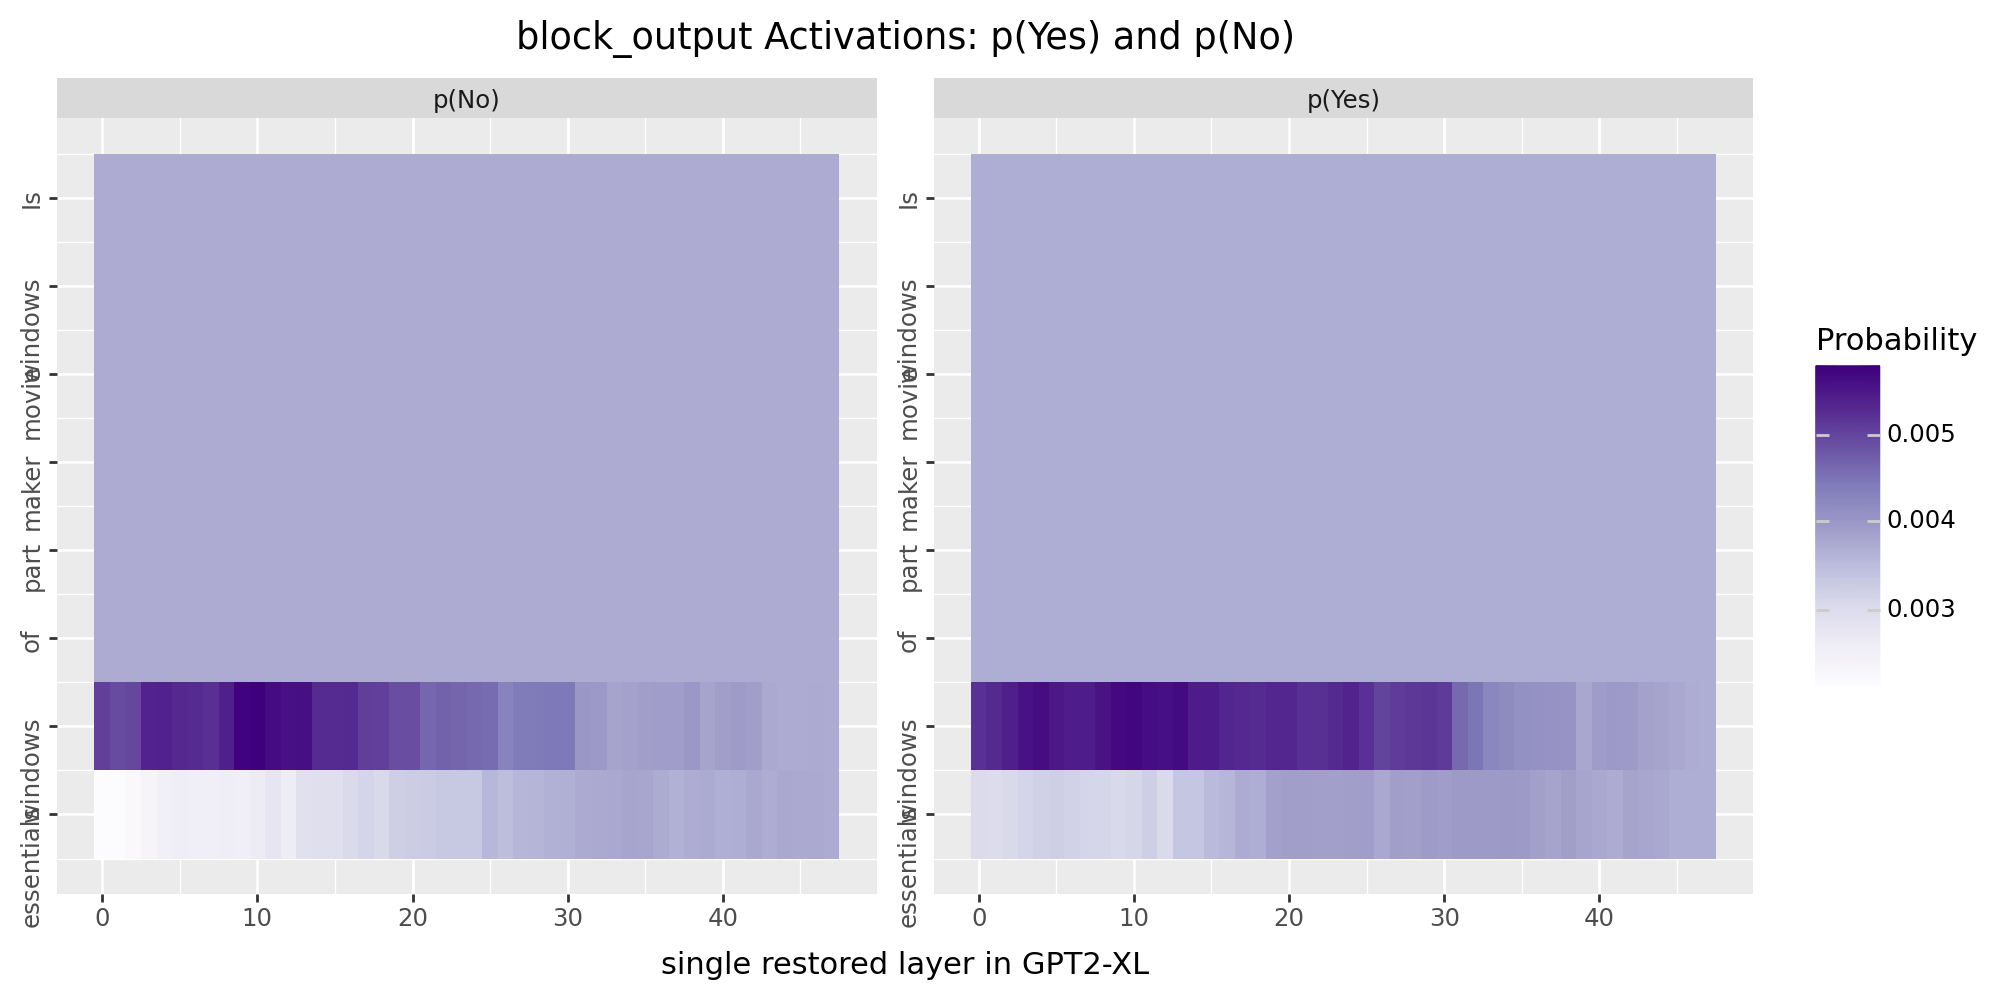

/home/woleek/PJN/.venv/lib/python3.12/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_tile : Removed 288 rows containing missing values.


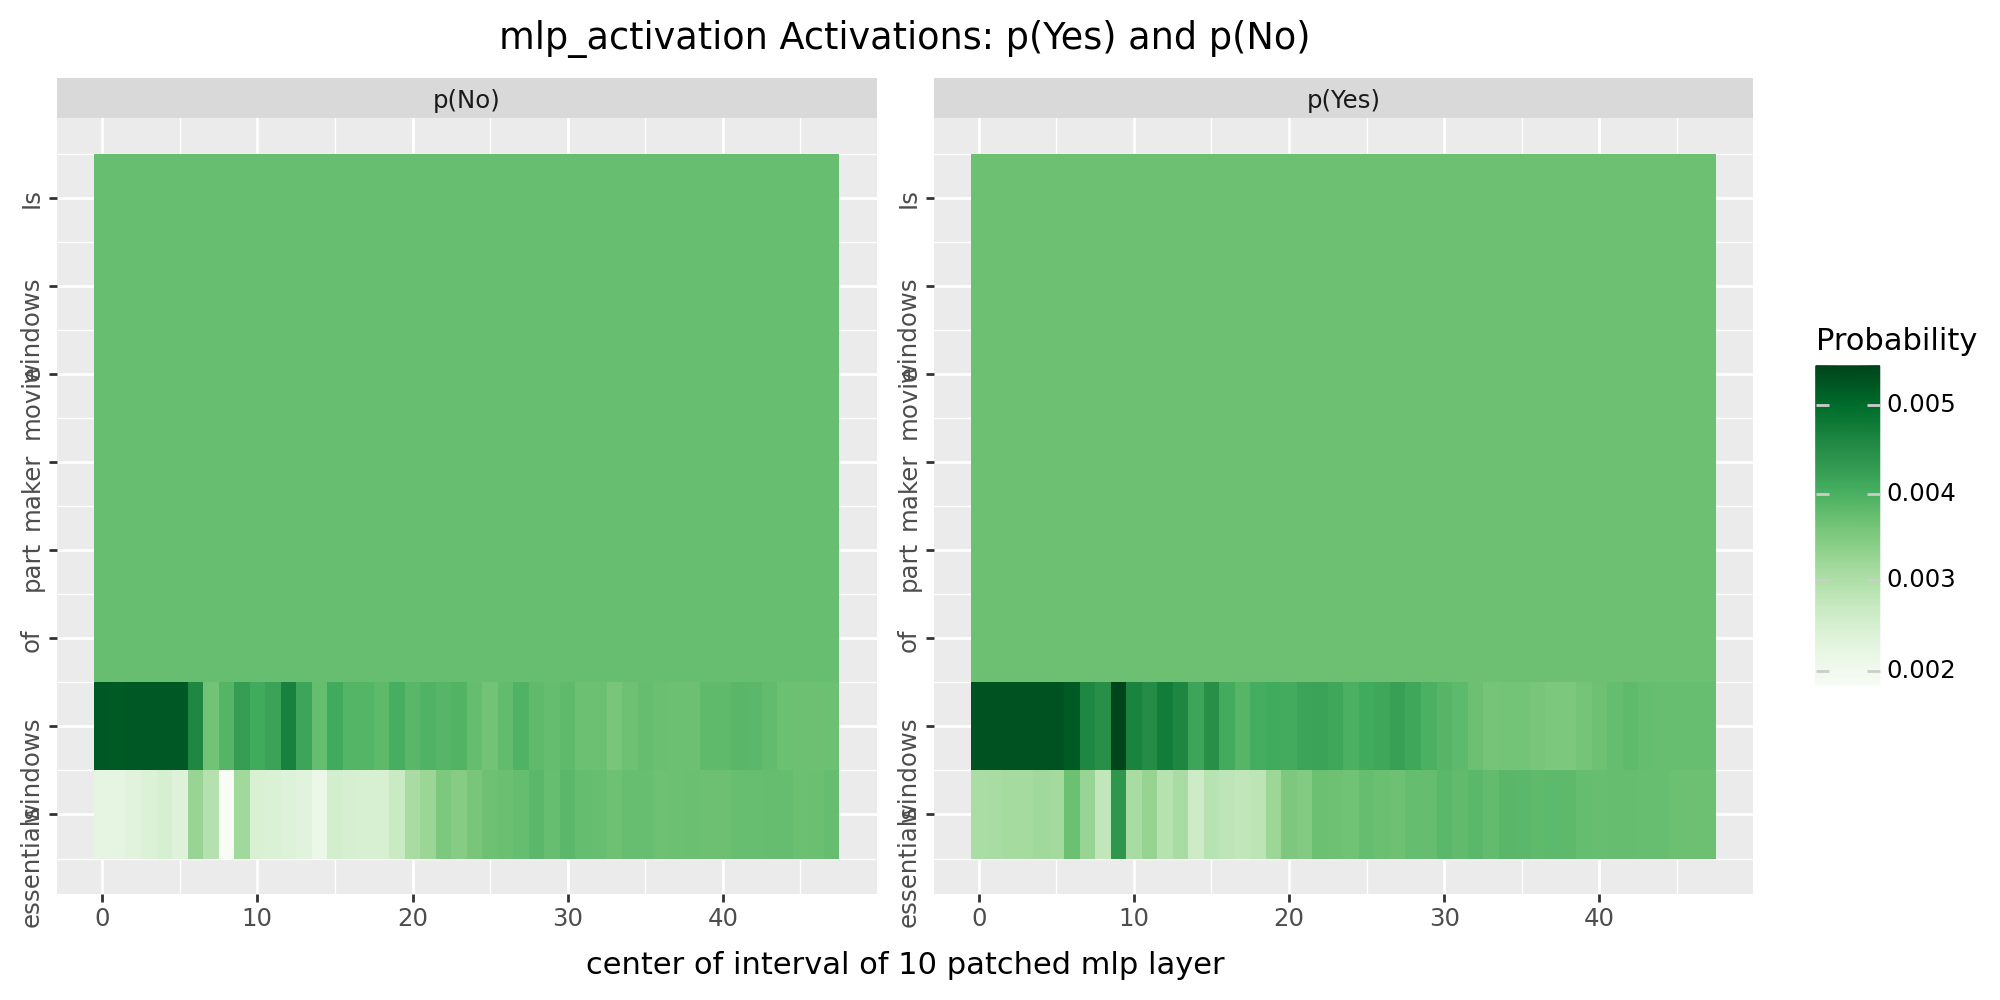

/home/woleek/PJN/.venv/lib/python3.12/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_tile : Removed 288 rows containing missing values.


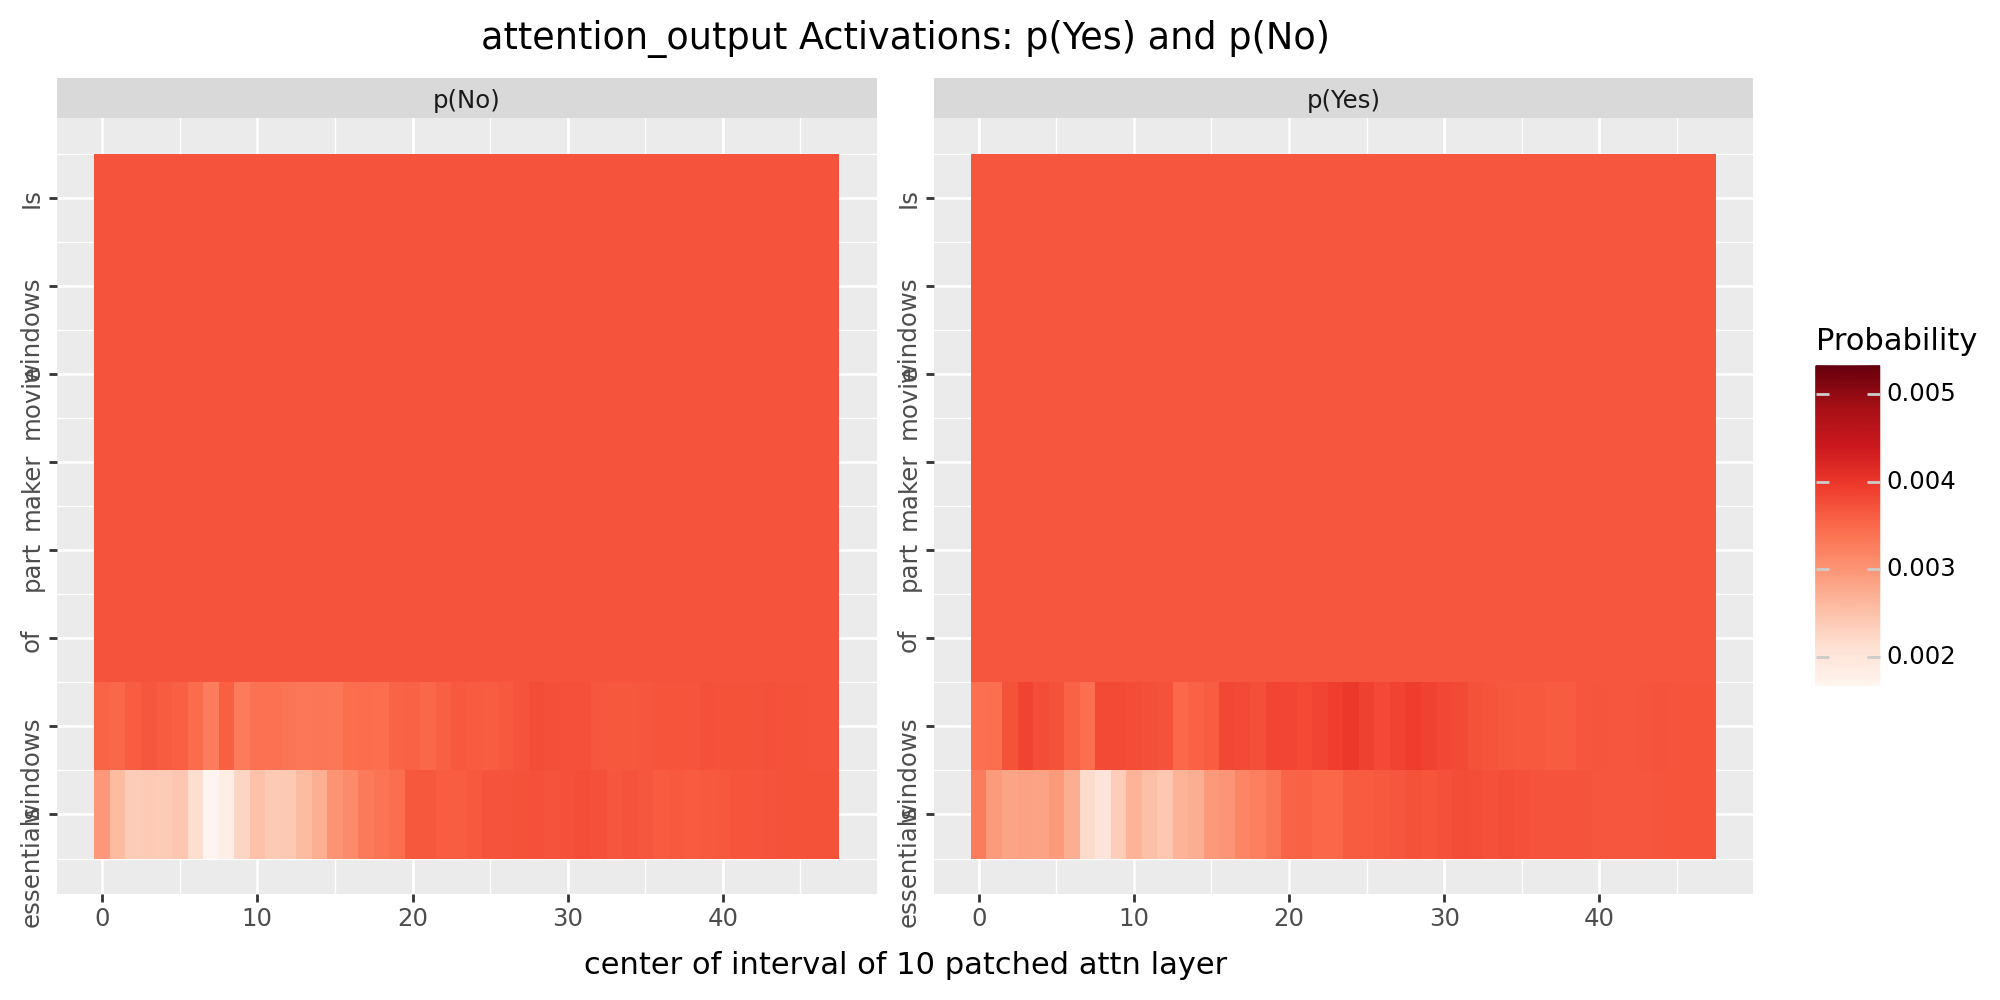

In [14]:
titles={
    "block_output": "single restored layer in GPT2-XL",
    "mlp_activation": "center of interval of 10 patched mlp layer",
    "attention_output": "center of interval of 10 patched attn layer"
}

colors={
    "block_output": "Purples",
    "mlp_activation": "Greens",
    "attention_output": "Reds"
} 
        
labels = ['Is','windows','movie','maker','part','of','windows','essentials']
breaks = list(range(0, len(labels)))
plot_activations(labels, breaks, colors, titles, path)

In [27]:
torch.cuda.empty_cache()

## GPT2-XL BoolQ

In [17]:
from dotenv import load_dotenv
load_dotenv()
hf_token = os.getenv("HUGGINGFACE_HUB_TOKEN")

from huggingface_hub import login
login(token=hf_token)

In [8]:
# init GPT-2 BoolQ model
config, tokenizer, gpt_boolq = pv.create_gpt2(name='utahnlp/boolq_gpt2-xl_seed-1')
gpt_boolq.to(device);

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

loaded model


In [12]:
print('GT: ', text_token)
factual_recall(text, gpt_boolq, tokenizer)

GT:   Yes
Is windows movie maker part of windows essentials? Answer:
_Yes                 0.17669516801834106
_No                  0.10044310986995697
_yes                 0.08774959295988083
_no                  0.06707040220499039
\n                   0.03876236081123352
_not                 0.03500565141439438
_Not                 0.03079880401492119
_"                   0.025840993970632553
_YES                 0.02205539681017399
_probably            0.020439209416508675


In [14]:
format_tokens(tokenizer, tokenizer(text)["input_ids"])

['Is',
 ' windows',
 ' movie',
 ' maker',
 ' part',
 ' of',
 ' windows',
 ' essentials',
 '?',
 ' Answer',
 ':']

In [16]:
subject_positions = [6,7]

corrupted_recall(text, gpt_boolq, tokenizer, subject_positions)

Is windows movie maker part of windows essentials? Answer:
_Yes                 0.14089031517505646
_No                  0.10375481843948364
_no                  0.10366412252187729
_yes                 0.06747836619615555
_not                 0.034229230135679245
\n                   0.031357262283563614
_maybe               0.025934696197509766
_Sort                0.024587983265519142
_Not                 0.02449174039065838
_probably            0.022183099761605263


In [25]:
path = './data/ex2/gpt2xl_boolq'
restored_run(text, gpt_boolq, tokenizer, subject_positions, path)

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

/home/woleek/PJN/.venv/lib/python3.12/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_tile : Removed 288 rows containing missing values.


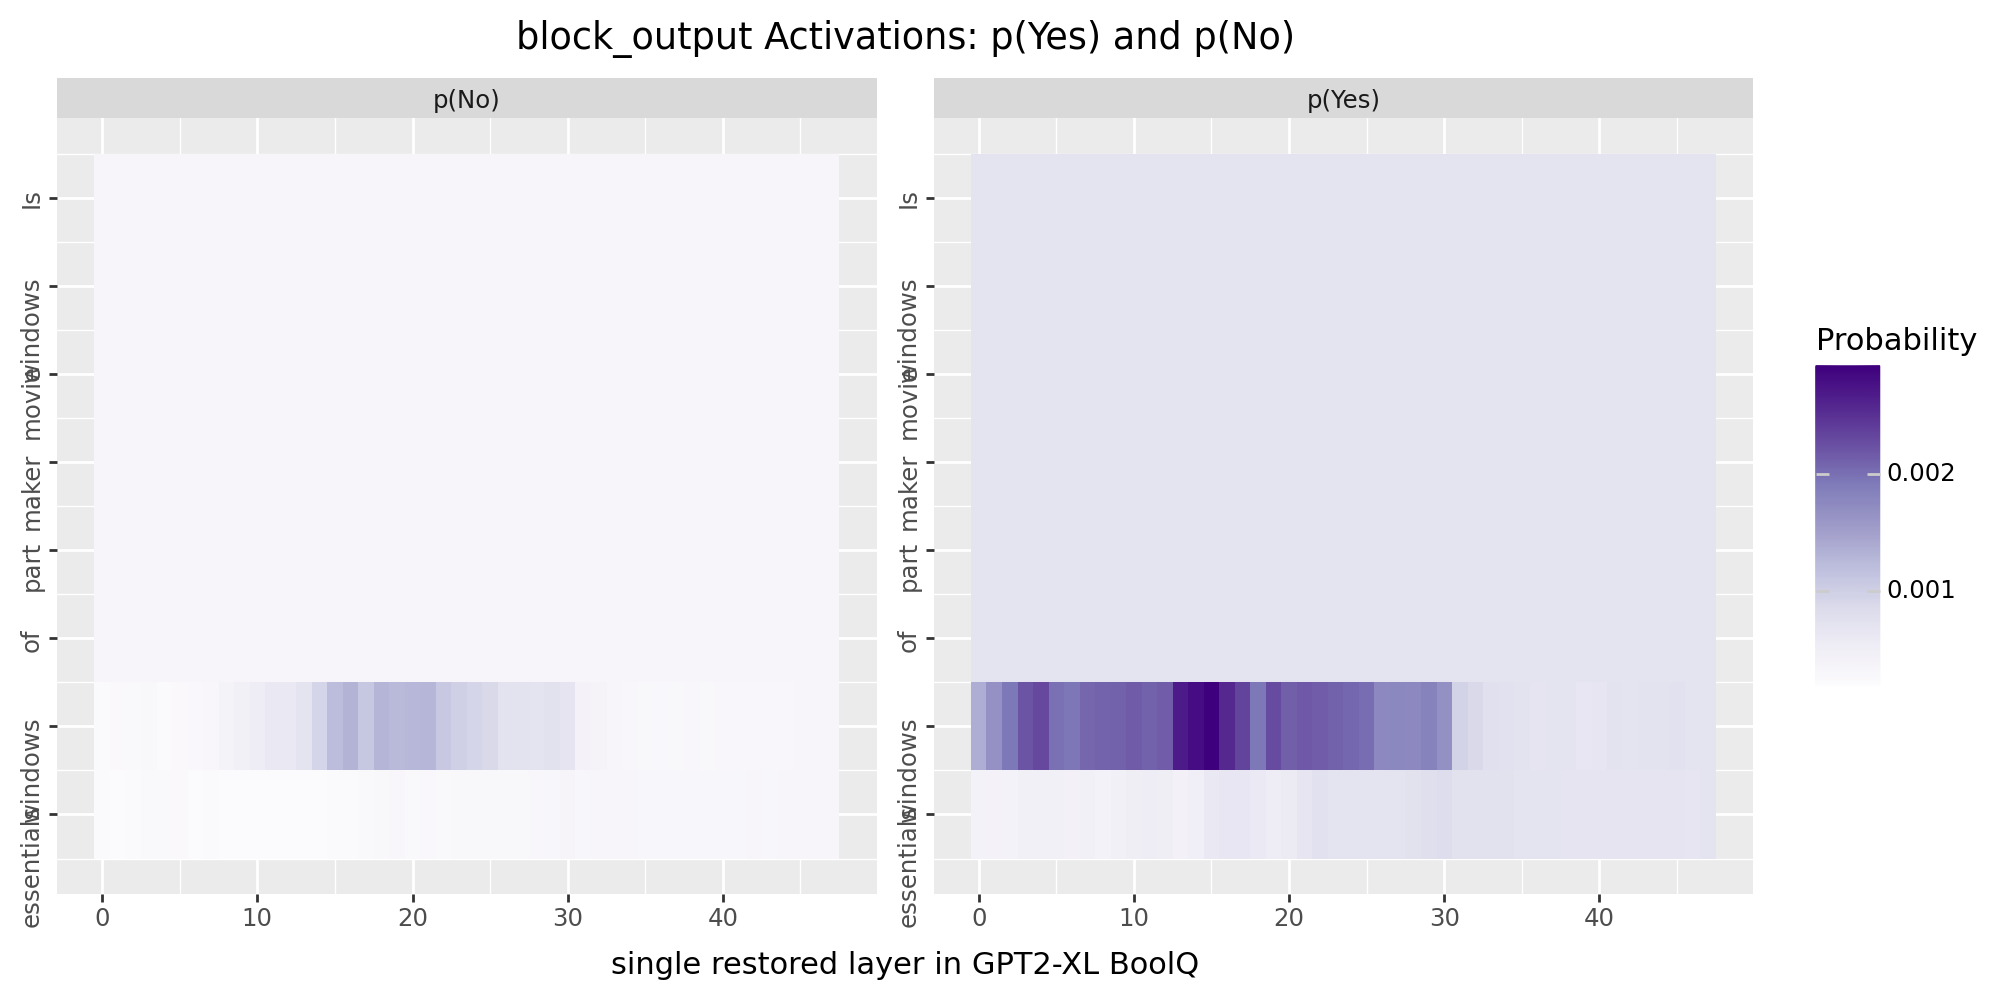

/home/woleek/PJN/.venv/lib/python3.12/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_tile : Removed 288 rows containing missing values.


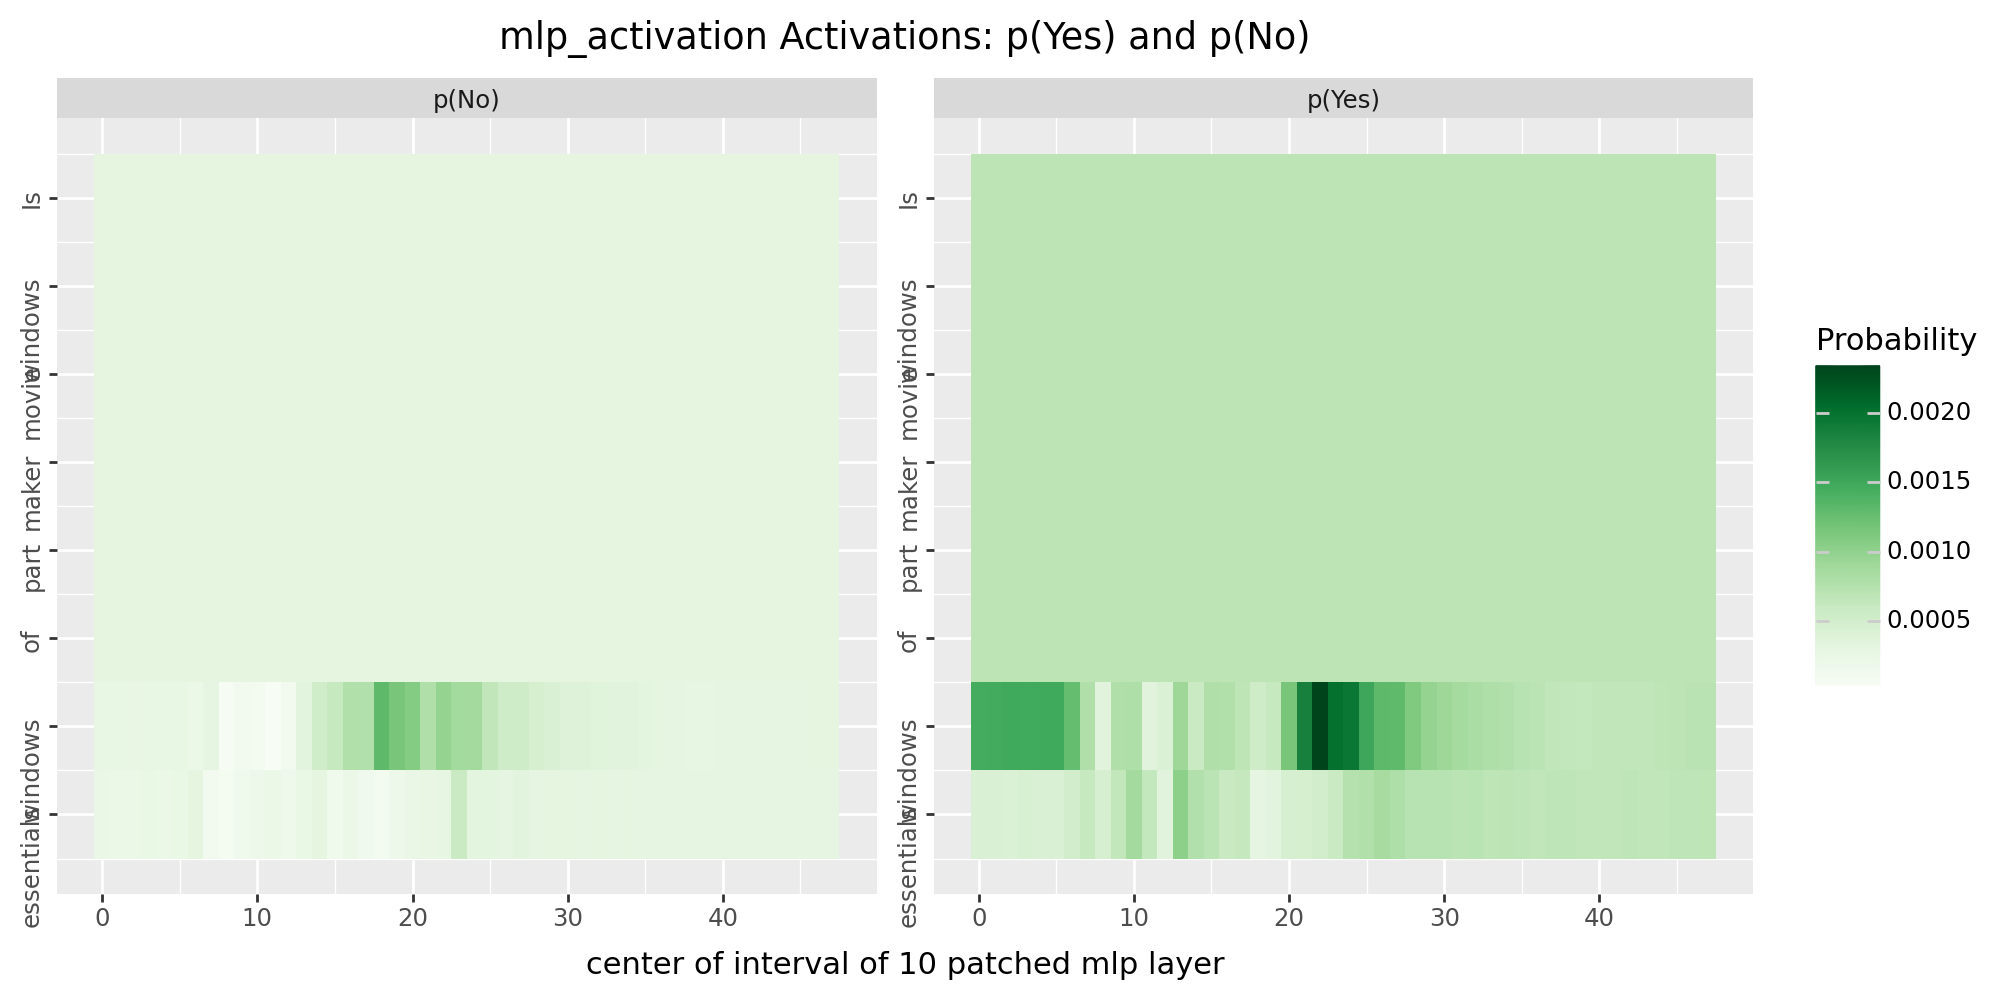

/home/woleek/PJN/.venv/lib/python3.12/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_tile : Removed 288 rows containing missing values.


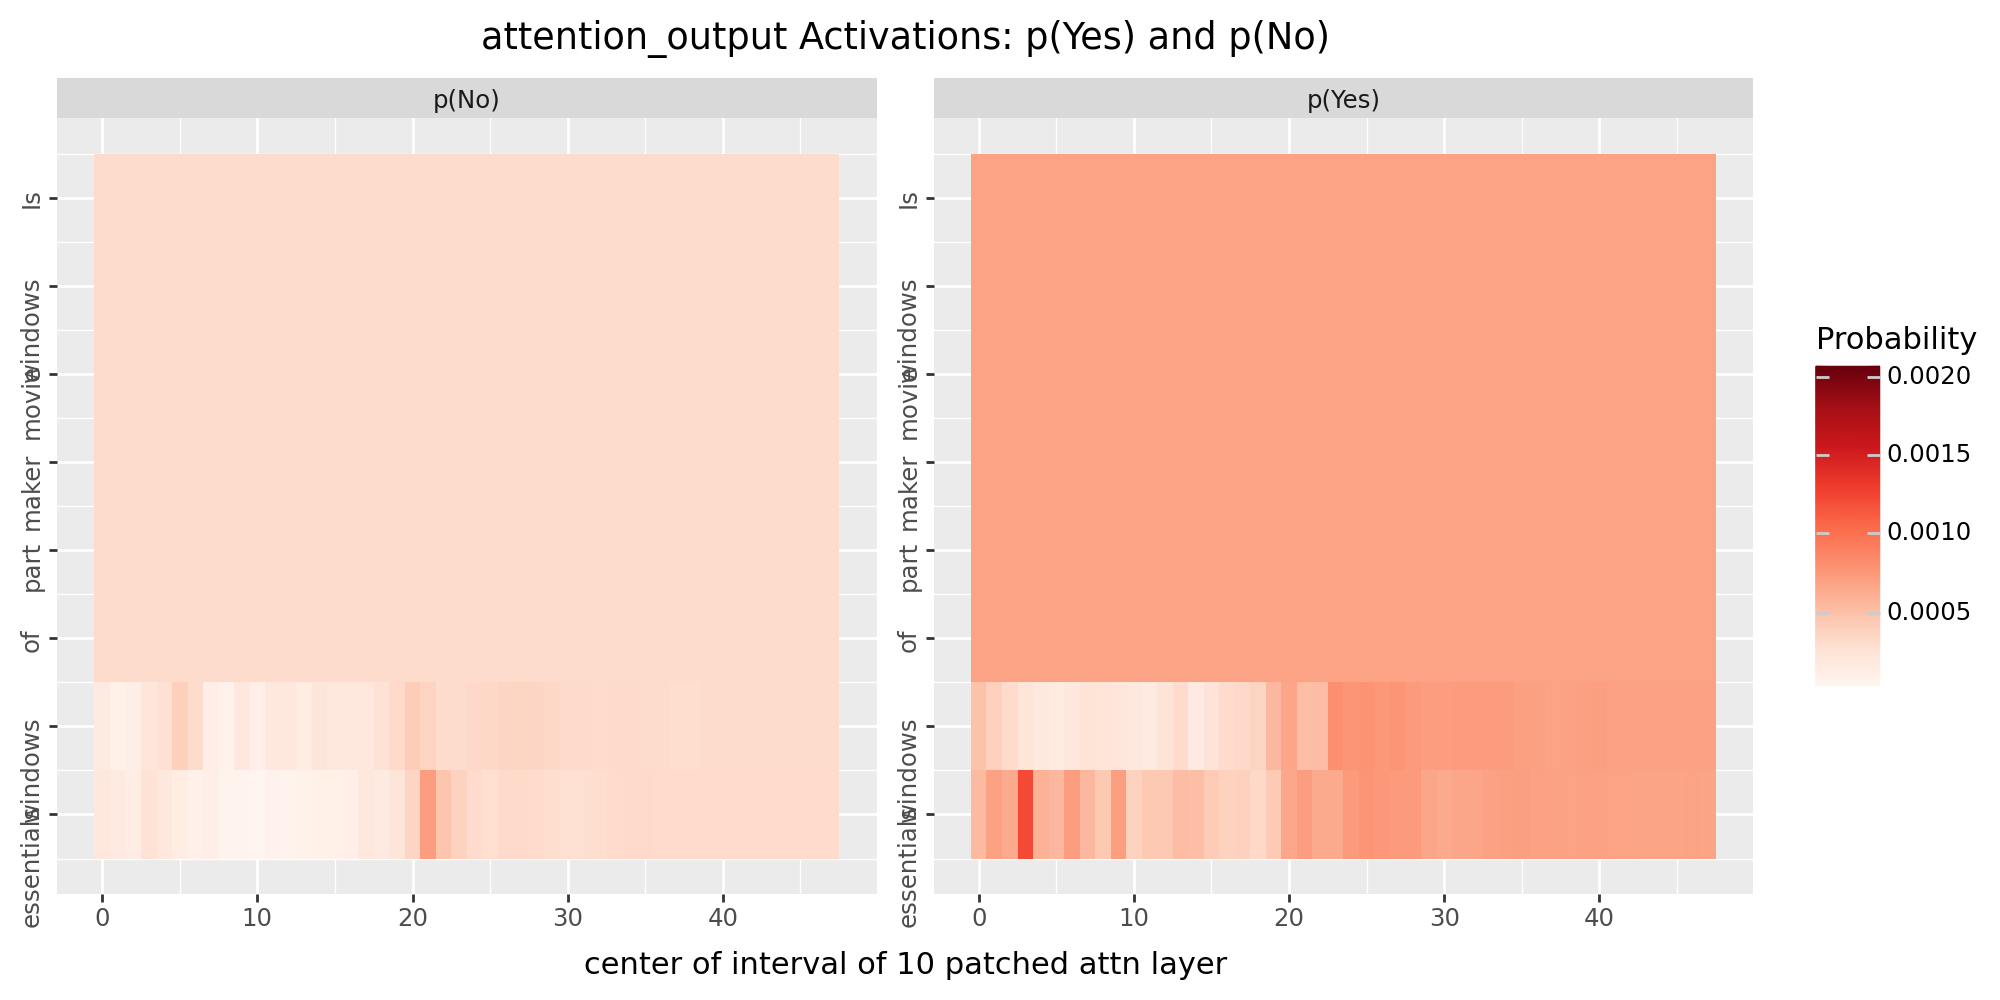

In [26]:
titles={
    "block_output": "single restored layer in GPT2-XL BoolQ",
    "mlp_activation": "center of interval of 10 patched mlp layer",
    "attention_output": "center of interval of 10 patched attn layer"
}

colors={
    "block_output": "Purples",
    "mlp_activation": "Greens",
    "attention_output": "Reds"
} 
        
labels = ['Is','windows','movie','maker','part','of','windows','essentials']
breaks = list(range(0, len(labels)))
plot_activations(labels, breaks, colors, titles, path)

Wnioski:
- Różnica we wzorcach aktywacji modelu `boolq_gpt2-xl_seed-1` i `gpt2-xl` wynika z faktu, że `boolq_gpt2-xl_seed-1` został dostrojony do zadania odpowiadania na pytania binarne, a aktywacje `gpt2-xl` są bardziej rozproszone między tokenami